In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/glaucoma/1255_right.jpg
/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/glaucoma/1482_left.jpg
/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/glaucoma/_398_8823411.jpg
/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/glaucoma/_309_4110303.jpg
/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/glaucoma/_13_697490.jpg
/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/glaucoma/_205_310538.jpg
/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/glaucoma/Glaucoma_040.png
/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/glaucoma/1256_right.jpg
/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/glaucoma/_221_3079640.jpg
/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/glaucoma/_392_9636183.jpg


In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report
from tensorflow.keras import layers, callbacks
import glob

2026-02-13 19:31:21.226559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771011081.438767      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771011081.495523      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771011082.009168      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771011082.009201      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771011082.009204      55 computation_placer.cc:177] computation placer alr

In [3]:
# Veri seti yolunu kontrol et
data_path = '/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset'
print("Dosya ve klasörler:")
for item in os.listdir(data_path):
    print(f"  - {item}")
    
# Alt klasörleri kontrol et
for root, dirs, files in os.walk(data_path):
    level = root.replace(data_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level == 0:  # Ana klasör
        for d in dirs:
            print(f"{indent}  📁 {d}/")
    elif level == 1:  # Alt klasörler
        print(f"{indent}    📊 {len(files)} dosya")
    if level > 1:
        break

Dosya ve klasörler:
  - glaucoma
  - normal
  - diabetic_retinopathy
  - cataract
dataset/
  📁 glaucoma/
  📁 normal/
  📁 diabetic_retinopathy/
  📁 cataract/
  glaucoma/
      📊 1007 dosya
  normal/
      📊 1074 dosya
  diabetic_retinopathy/
      📊 1098 dosya
  cataract/
      📊 1038 dosya


In [4]:
cataract_images = glob.glob("/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/cataract/*.jpg")
diabetic_images = glob.glob("/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/diabetic_retinopathy/*.jpeg")
glaucoma_images = glob.glob("/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/glaucoma/*.jpg")
normal_images = glob.glob("/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset/normal/*.jpg")

In [5]:
len(cataract_images) , len(diabetic_images), len(glaucoma_images), len(normal_images)

(938, 1098, 906, 1074)

In [6]:
dataset_path = '/kaggle/input/datasets/gunavenkatdoddi/eye-diseases-classification/dataset'


### Data Splitting

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    batch_size=32,  
    image_size=(224,224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels="inferred", 
    label_mode="int",
    batch_size=32,
    image_size=(224,224),
    shuffle=True,  
    seed=42,
    validation_split=0.2,
    subset="validation"
)

print(f"\n Train seti: {len(train_ds)} batch")
print(f" Validation seti: {len(test_ds)} batch")
print(f" Sınıflar: {train_ds.class_names}")

Found 4217 files belonging to 4 classes.
Using 3374 files for training.


I0000 00:00:1771011105.159678      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771011105.165635      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 4217 files belonging to 4 classes.
Using 843 files for validation.

 Train seti: 106 batch
 Validation seti: 27 batch
 Sınıflar: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [8]:
CLASS_NAMES = train_ds.class_names

In [9]:
print(CLASS_NAMES)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


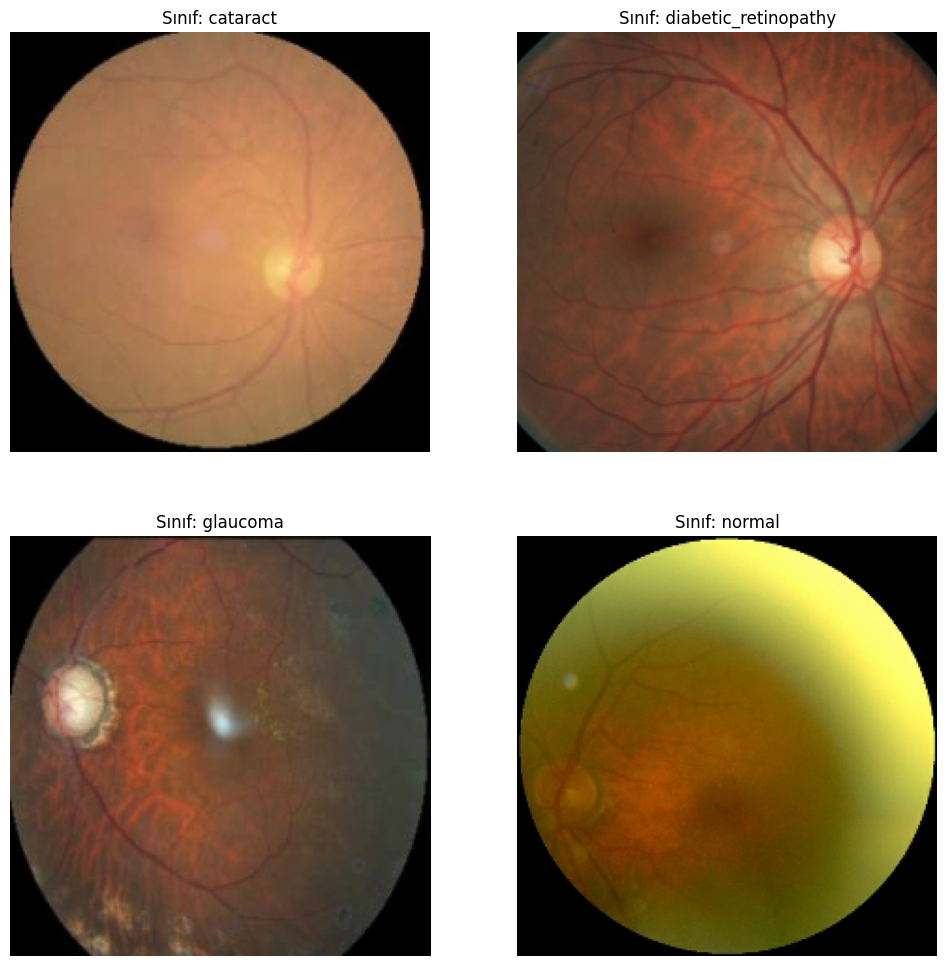

In [15]:
from matplotlib import pyplot as plt

found_images = {}

for images, labels in train_ds.take(3):
    for i in range(len(images)):
        label_idx = labels[i].numpy()
        class_name = train_ds.class_names[label_idx]

        if class_name not in found_images:
            found_images[class_name] = images[i].numpy().astype("uint8")

        if len(found_images) == 4:
            break
    if len(found_images) == 4:
        break

# Görselleştirme kısmı
plt.figure(figsize=(12, 12))
for i, class_name in enumerate(train_ds.class_names):
    if class_name in found_images:
        plt.subplot(2, 2, i + 1)
        plt.imshow(found_images[class_name])
        plt.title(f"Sınıf: {class_name}")
        plt.axis("off")

In [41]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)

])

In [42]:
data_augmentation2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

### Train e augmentation uygulama ve test in boyutunu ölçeklendirme


In [43]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds_cnn = train_ds.prefetch(AUTOTUNE)

In [44]:
test_ds_cnn = test_ds.prefetch(AUTOTUNE)

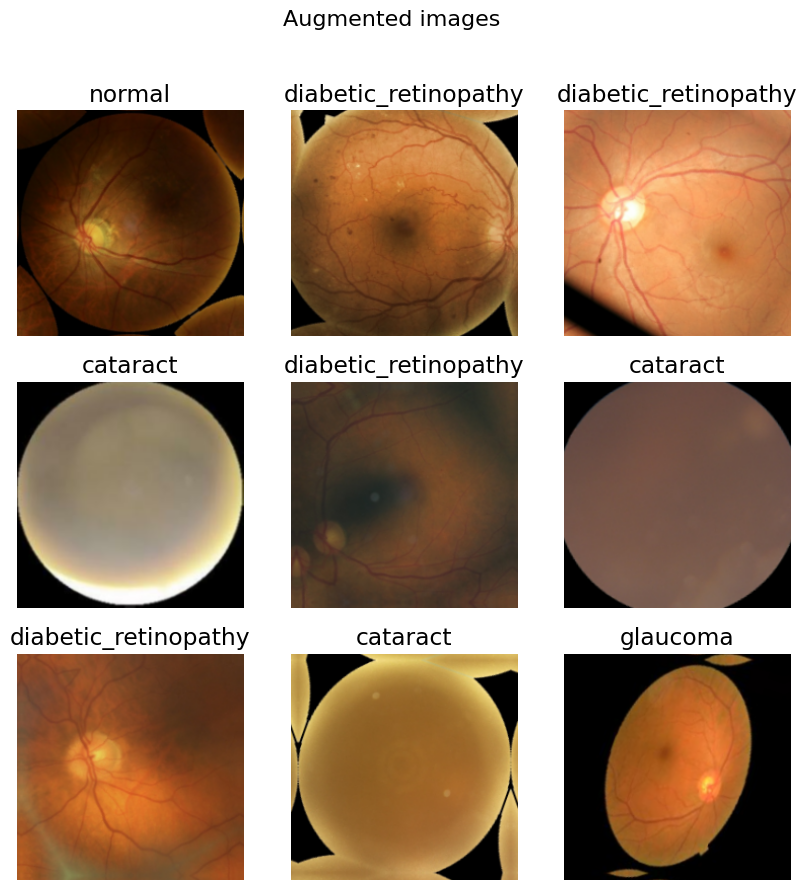

In [45]:
plt.figure(figsize=(10,10))
for images, labels in train_ds_cnn.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        augmented_img = data_augmentation(tf.expand_dims(images[i], 0), training=True)
        final_img = (augmented_img[0].numpy() * 255).astype("uint8")
        plt.imshow(final_img)
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis('off')

plt.suptitle("Augmented images", fontsize=16)
plt.show()

In [46]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels)

(32, 224, 224, 3)
tf.Tensor([3 3 2 2 1 3 2 1 1 2 1 1 1 3 1 2 0 0 3 2 3 1 1 2 0 0 3 0 0 0 2 1], shape=(32,), dtype=int32)


### CNN - Transfer Learning with EfficientNet - Fine-tuning

## CNN

In [47]:
cnn_model = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,

    # CNN katmanları
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [48]:
optimizer = tf.keras.optimizers.Adam(0.0001)
cnn_model.compile(optimizer=optimizer,
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [50]:

#early stopping callback
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=12,
    restore_best_weights=True
)

#Eğitim yerinde saymaya başladığında learning rate düşürür
reduceLR=callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)
#en düşük val_loss u veren modeli kaydeder
model_check=callbacks.ModelCheckpoint(
    filepath="eye_cnn_weights/eye_cnn_model.keras",
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0
)

history = cnn_model.fit(
    train_ds_cnn,
    epochs=50,
    validation_data=test_ds_cnn,
    callbacks=[early_stop, reduceLR, model_check],
    verbose=1
)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.3774 - loss: 1.3543 - val_accuracy: 0.3238 - val_loss: 1.3721 - learning_rate: 1.0000e-04
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 0.4364 - loss: 1.2541 - val_accuracy: 0.2716 - val_loss: 1.3698 - learning_rate: 1.0000e-04
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.4638 - loss: 1.2049 - val_accuracy: 0.2752 - val_loss: 1.3681 - learning_rate: 1.0000e-04
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.5089 - loss: 1.1557 - val_accuracy: 0.3167 - val_loss: 1.3151 - learning_rate: 1.0000e-04
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.5042 - loss: 1.1412 - val_accuracy: 0.3606 - val_loss: 1.2388 - learning_rate: 1.0000e-04
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - accuracy: 0.5127 - loss: 1.1184 - val_accuracy: 0.4864 - val_loss: 1.1426 - learning_rate: 1.0000e-04
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 16

## accuracy: 0.7025 - loss: 0.7160 - val_accuracy: 0.6548 - val_loss: 0.8724

In [51]:
cnn_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,622 (1.27 MB)

 Trainable params: 110,724 (432.52 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 221,450 (865.04 KB)

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:0.709839940071106\nValidation Accuracy: 0.6548042893409729')

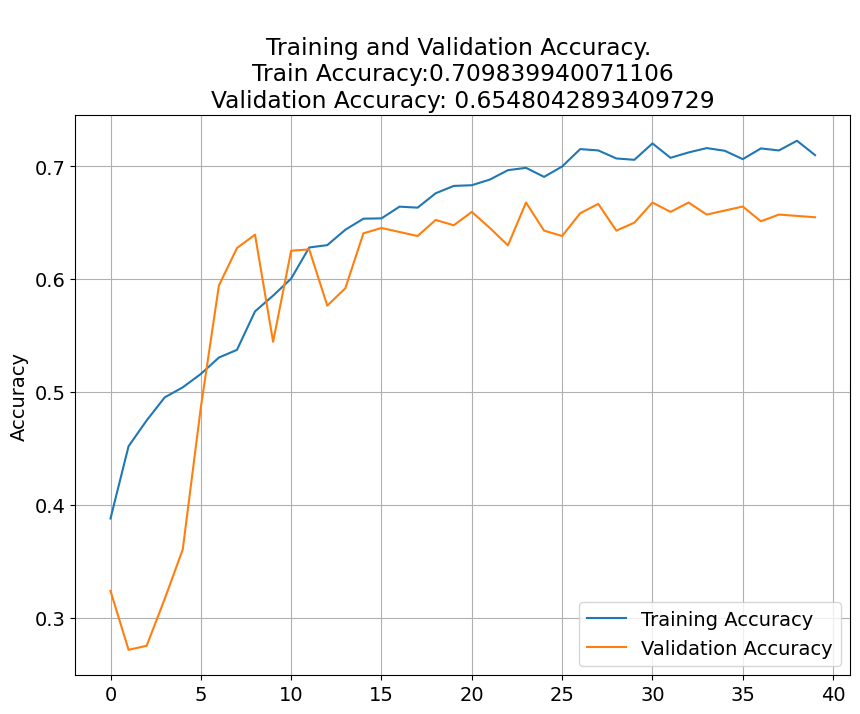

In [52]:
# sonucları kaydediyoruz
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# plot
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

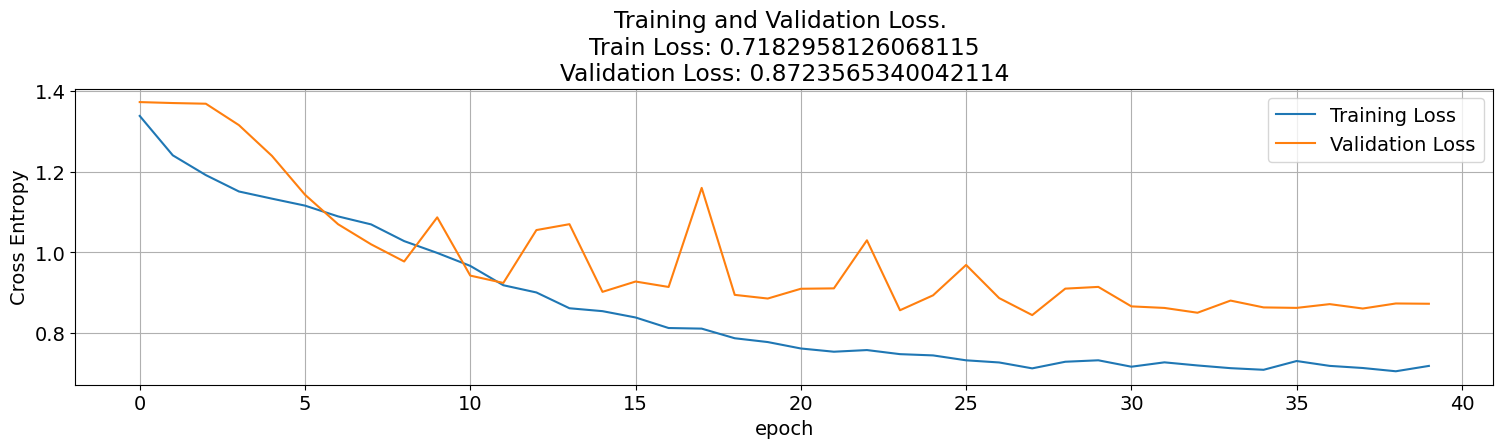

In [53]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

## EfficientNet

In [54]:
from tensorflow.keras.applications.efficientnet import preprocess_input

model_check_2 = callbacks.ModelCheckpoint(
    filepath="eye_efficient_weights/eye_efficient_model.keras",
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

#early stopping callback
early_stop2 = callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=12,
    restore_best_weights=True
)

#Eğitim yerinde saymaya başladığında learning rate düşürür
reduceLR2=callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable=False

efficient_model = tf.keras.Sequential([
    data_augmentation2, 
    tf.keras.layers.Lambda(preprocess_input),

    base_model,    
    
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
efficient_model.compile(optimizer=optimizer,
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [56]:
history_efficient = efficient_model.fit(
    train_ds_cnn,
    epochs=50,
    validation_data=test_ds_cnn,
    callbacks=[early_stop2, reduceLR2, model_check_2],
    verbose=1
)

Epoch 1/50


E0000 00:00:1771013041.814518      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_13_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4907 - loss: 1.3731
Epoch 1: val_loss improved from inf to 0.83617, saving model to eye_efficient_weights/eye_efficient_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.4918 - loss: 1.3700 - val_accuracy: 0.7011 - val_loss: 0.8362 - learning_rate: 1.0000e-04
Epoch 2/50
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7369 - loss: 0.6932
Epoch 2: val_loss improved from 0.83617 to 0.68818, saving model to eye_efficient_weights/eye_efficient_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.7372 - loss: 0.6925 - val_accuracy: 0.7200 - val_loss: 0.6882 - learning_rate: 1.0000e-04
Epoch 3/50
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7765 - loss: 0.5999
Epoch 3: val_loss improved from 0.68818 to 0.63455, saving model to eye_efficient_weights/eye_efficient_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.7766 - loss: 0.5992 - val_accuracy: 0.7307 - val_los

## accuracy: 0.8658 - loss: 0.3498 - val_accuracy: 0.8066 - val_loss: 0.5457

In [57]:
efficient_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,038,513 (19.22 MB)

 Trainable params: 329,476 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

 Optimizer params: 658,954 (2.51 MB)

In [101]:
print(acc2)

[0.6061055064201355, 0.7551867365837097, 0.7848251461982727, 0.8029045462608337, 0.8156490921974182, 0.8159454464912415, 0.8393598198890686, 0.833135724067688, 0.8417308926582336, 0.8402489423751831, 0.847065806388855, 0.8615885972976685, 0.8509187698364258, 0.8636633157730103, 0.8624777793884277, 0.8743331432342529, 0.8772969841957092, 0.867516279220581, 0.8672199249267578, 0.8701837658882141, 0.8707765340805054, 0.8710728883743286, 0.8695909976959229, 0.8707765340805054, 0.8689982295036316, 0.8758150339126587, 0.8743331432342529]


Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:0.8743331432342529\nValidation Accuracy: 0.8066429495811462')

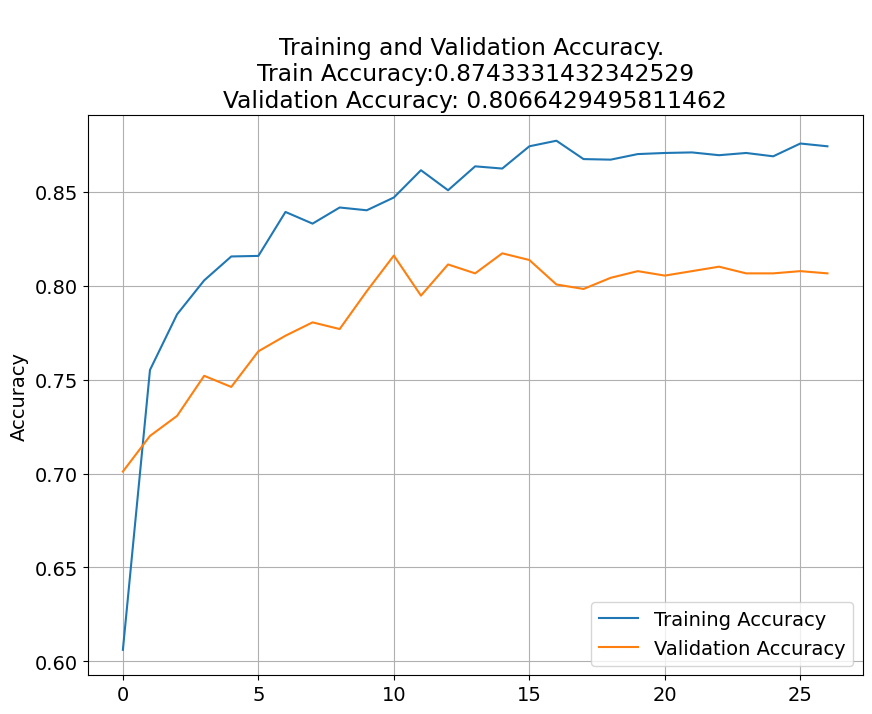

In [58]:
# sonucları kaydediyoruz
acc2 = history_efficient.history['accuracy']
val_acc2 = history_efficient.history['val_accuracy']
loss2 = history_efficient.history['loss']
val_loss2 = history_efficient.history['val_loss']

# plot
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc2, label='Training Accuracy')
plt.plot(val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc2[-1])}\nValidation Accuracy: {str(val_acc2[-1])}')

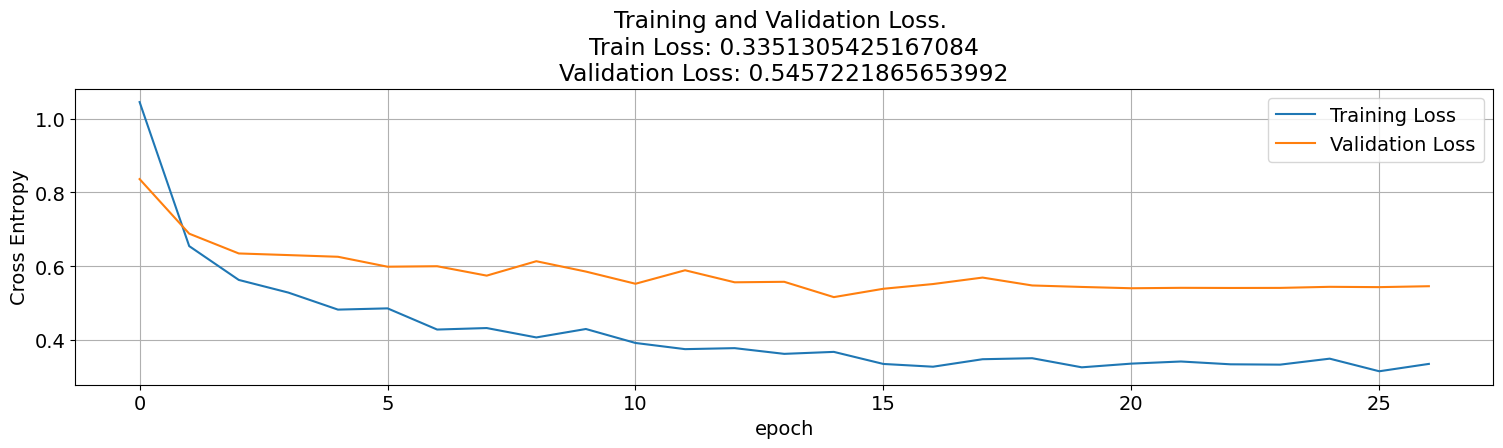

In [59]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss2[-1])}\nValidation Loss: {str(val_loss2[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

## Fine-Tuning

In [73]:
base_model_2 = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

def unfreeze_model(model):
    # BatchNorm katmanları haric en son 20 katmanı unfrozen yapıyoruz
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    return model

fine_tune_efficientNetb0 = unfreeze_model(base_model_2)

fine_tune_model = tf.keras.Sequential([
    data_augmentation2, 
    tf.keras.layers.Lambda(preprocess_input),
    
    fine_tune_efficientNetb0,
    
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=1e-5)
fine_tune_model.compile(
    optimizer=optimizer, 
    loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [74]:
history_fine_tune = fine_tune_model.fit(
    train_ds_cnn,
    epochs=50,
    validation_data=test_ds_cnn,
    callbacks=[early_stop2, reduceLR2, model_check_2],
    verbose=1
)

Epoch 1/50


E0000 00:00:1771015480.780843      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_15_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.2823 - loss: 2.1763
Epoch 1: val_loss did not improve from 0.51616
106/106 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.2829 - loss: 2.1738 - val_accuracy: 0.4484 - val_loss: 1.2182 - learning_rate: 1.0000e-05
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.5103 - loss: 1.3522
Epoch 2: val_loss did not improve from 0.51616
106/106 ━━━━━━━━━━━━━━━━━━━━ 38s 359ms/step - accuracy: 0.5105 - loss: 1.3514 - val_accuracy: 0.5860 - val_loss: 0.9696 - learning_rate: 1.0000e-05
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6142 - loss: 1.0979
Epoch 3: val_loss did not improve from 0.51616
106/106 ━━━━━━━━━━━━━━━━━━━━ 39s 363ms/step - accuracy: 0.6142 - loss: 1.0978 - val_accuracy: 0.6501 - val_loss: 0.8426 - learning_rate: 1.0000e-05
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6347 - loss: 1.0073
Epoch 4: val_loss did not improve from 0.51616
106/106 ━━━━━━━━━━━━━━━━━━━

## accuracy: 0.9052 - loss: 0.2554 - val_accuracy: 0.8849 - val_loss: 0.3613

In [75]:
fine_tune_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,053,609 (49.80 MB)

 Trainable params: 4,337,024 (16.54 MB)

 Non-trainable params: 42,535 (166.16 KB)

 Optimizer params: 8,674,050 (33.09 MB)

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:0.9013040661811829\nValidation Accuracy: 0.8849347829818726')

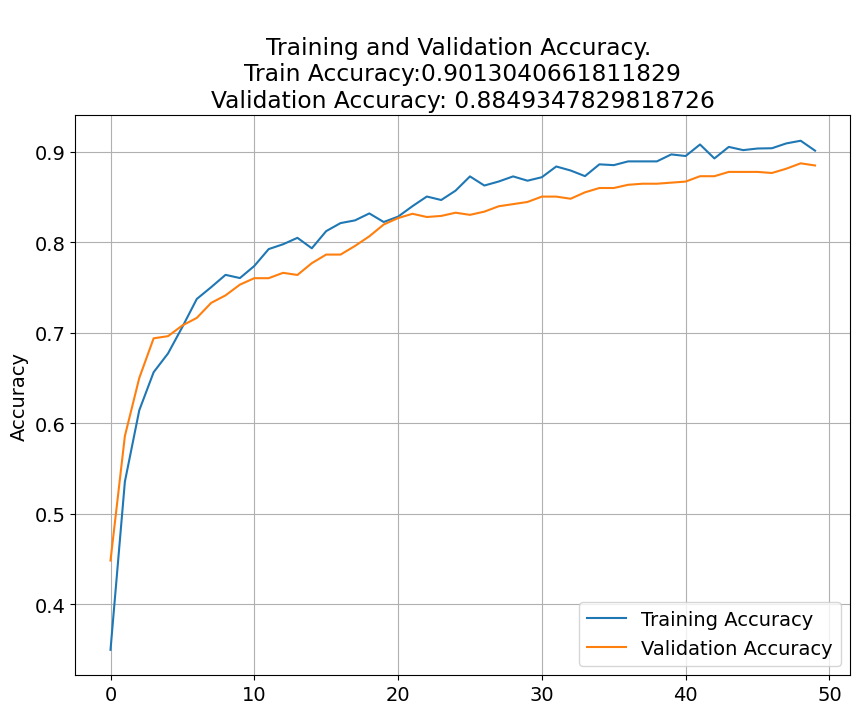

In [76]:
# sonucları kaydediyoruz
acc3 = history_fine_tune.history['accuracy']
val_acc3 = history_fine_tune.history['val_accuracy']
loss3 = history_fine_tune.history['loss']
val_loss3 = history_fine_tune.history['val_loss']

# plot
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc3, label='Training Accuracy')
plt.plot(val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc3[-1])}\nValidation Accuracy: {str(val_acc3[-1])}')

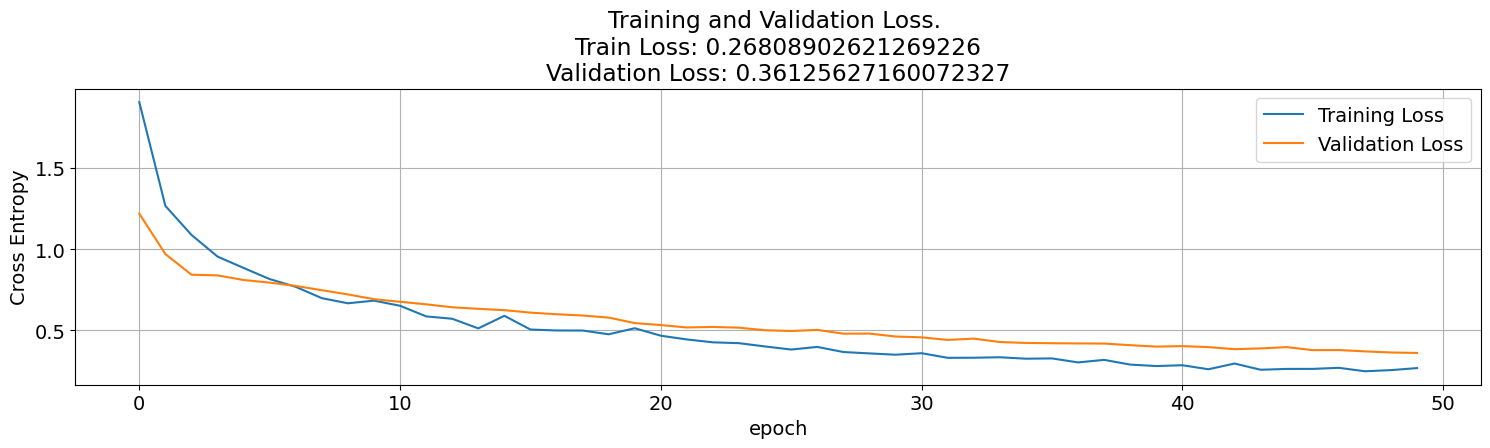

In [77]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss3, label='Training Loss')
plt.plot(val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss3[-1])}\nValidation Loss: {str(val_loss3[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [104]:
# CNN
cnn_preds = cnn_model.predict(test_ds_cnn)
cnn_pred_labels = np.argmax(cnn_preds, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


In [105]:
# EfficientNet Transfer learning
eff_preds = efficient_model.predict(test_ds_cnn)
eff_pred_labels = np.argmax(eff_preds, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


In [106]:
# EfficientNet Fine-Tune
fine_tune_preds = fine_tune_model.predict(test_ds_cnn)
fine_tune_preds_labels = np.argmax(fine_tune_preds, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step


In [108]:
# 1. Değişken ismini test_ds olarak güncelledik
print("CNN modeli test ediliyor...")
cnn_loss, cnn_acc = cnn_model.evaluate(test_ds, verbose=0)

print("EfficientNet modeli test ediliyor...")
eff_loss, eff_acc = efficient_model.evaluate(test_ds, verbose=0)

print("Fine-Tuned EfficientNet modeli test ediliyor...")
# Fine-tune modelinin değişken adının 'fine_tuned_efficient_model' olduğunu varsayıyorum
ft_loss, ft_acc = fine_tune_model.evaluate(test_ds, verbose=0)

# 2. Şimdi karşılaştırma tablonu oluşturabilirsin
print("\n" + "="*60)
print(" "*15 + "MODEL PERFORMANS KARŞILAŞTIRMASI")
print("="*60)
print(f"{'Model':<25} {'Validation Accuracy':<20} {'Durum':<15}")
print("-"*60)

models = {
    'CNN': cnn_acc,
    'EfficientNet (Transfer Learnig)': eff_acc,
    'EfficientNet (Fine-tune)': ft_acc
}

best_model = max(models, key=models.get)
for model, acc in models.items():
    status = "EN İYİ" if model == best_model else "Başarılı" if acc > 0.80 else "Normal"
    print(f"{model:<25} {acc:<20.4f} ({acc*100:.2f}%) {status}")

print("="*60)

CNN modeli test ediliyor...
EfficientNet modeli test ediliyor...
Fine-Tuned EfficientNet modeli test ediliyor...

               MODEL PERFORMANS KARŞILAŞTIRMASI
Model                     Validation Accuracy  Durum          
------------------------------------------------------------
CNN                       0.6667               (66.67%) ⚡ Normal
EfficientNet (TL)         0.8173               (81.73%) ✓ Başarılı
EfficientNet (Fine-tune)  0.8849               (88.49%) 🏆 EN İYİ
